In [1]:
imgsize = 64
seeds = 0

In [2]:
import numpy as np
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot
import six.moves.cPickle as pickle
import gzip
import os
import sys
from sklearn.preprocessing import MinMaxScaler

###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        self.lamda = lamda                  # weight decay parameter
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1)
        
        rand = np.random.RandomState(int(time.time()))
        
        W1 = np.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = np.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = np.zeros((hidden_size, 1))
        b2 = np.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """

        self.theta = np.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + np.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
#         print(np.shape(input))
        """ Extract weights and biases from 'theta' input """
        
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        
        hidden_layer = self.sigmoid(np.dot(W1, input) + b1)
        output_layer = self.sigmoid(np.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = np.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input
        
        sum_of_squares_error = 0.5 * np.sum(np.multiply(diff, diff)) / input.shape[1]
        weight_decay         = 0.5 * self.lamda * (np.sum(np.multiply(W1, W1)) +
                                                   np.sum(np.multiply(W2, W2)))
        KL_divergence        = self.beta * np.sum(self.rho * np.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * np.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        loss_                = torch.mean(output**2)/2 \
                                + c1*loss_function(output, X) \
                                + c2*torch.mean(torch.minimum(output - Xmin, torch.zeros(output.shape))**2) \
                                + c3*torch.mean(torch.maximum(output - Xmax, torch.zeros(output.shape))**2)
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        
        del_out = np.multiply(diff, np.multiply(output_layer, 1 - output_layer))
        del_hid = np.multiply(np.dot(np.transpose(W2), del_out) + np.transpose(np.matrix(KL_div_grad)), 
                                 np.multiply(hidden_layer, 1 - hidden_layer))
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = np.dot(del_hid, np.transpose(input))
        W2_grad = np.dot(del_out, np.transpose(hidden_layer))
        b1_grad = np.sum(del_hid, axis = 1)
        b2_grad = np.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = np.array(W1_grad)
        W2_grad = np.array(W2_grad)
        b1_grad = np.array(b1_grad)
        b2_grad = np.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = np.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]


""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side, 3),
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()


def executeSparseAutoencoder(training_data):

    """ Define the parameters of the Autoencoder """
#     print(training_data.shape)
    vis_patch_side = imgsize      # side length of sampled image patches
    hid_patch_side = 40     # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = training_data.shape[-1]  # number of training examples
    max_iterations = 500   # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side * 3  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
   
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations,'disp': True})
    opt_theta = opt_solution.x
    opt_W1 = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    opt_W2 = opt_theta[encoder.limit1 : encoder.limit2].reshape(visible_size, hidden_size)
    opt_b1 = opt_theta[encoder.limit2 : encoder.limit3].reshape(hidden_size, 1)
    opt_b2 = opt_theta[encoder.limit3 : encoder.limit4].reshape(visible_size, 1)
    """ Visualize the obtained optimal W1 weights """
    compressedInputs= encoder.sigmoid(numpy.dot(opt_W1, training_data) + opt_b1)
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)
    return opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs

def executeMain(training_data):
    opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeSparseAutoencoder(training_data)
    return opt_W1,opt_W2,opt_b1,opt_b2,np.transpose(compressedInputs)

In [3]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [4]:
from __future__ import print_function
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from six.moves import urllib

torch.manual_seed(seeds)
plt.ion()  
import tensorflow
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
import os
from sklearn.svm import SVC
import scipy.linalg as la
from numpy.random import seed
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import train_test_split
seed(seeds)
tensorflow.random.set_seed(seeds)

import numpy_indexed as npi



2022-10-27 18:38:23.483711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 18:38:23.647948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 18:38:23.647974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 18:38:23.678043: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 18:38:24.307848: W tensorflow/stream_executor/pla

In [5]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

full_dataset = torchvision.datasets.ImageFolder(root = '/data/siddhant/MedicalSTN/LavinaData', 
                                     transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Resize((imgsize,imgsize)),
                   ]))

X, y = torch.vstack([full_dataset[i][0].unsqueeze(0) for i in range(len(full_dataset))]), torch.tensor(full_dataset.targets)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
samples_mask = npi.multiplicity(y) >= 5
y = y[samples_mask]
X = X[samples_mask]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state = seeds)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=seeds) # 0.25 x 0.8 = 0.2
Xtrainshape = X_train.shape
Xvalshape = X_val.shape
Xtestshape = X_test.shape
X_train = X_train.reshape(Xtrainshape[0],-1)
X_val = X_val.reshape(Xvalshape[0],-1)
X_test = X_test.reshape(Xtestshape[0],-1)



In [6]:
X.shape

(2432, 3, 64, 64)

(1458,) (1458, 12288)
(1458, 12288)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =     39335488     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57661D+03    |proj g|=  2.61325D+00

At iterate    1    f=  1.31598D+03    |proj g|=  1.44192D+00

At iterate    2    f=  5.84150D+02    |proj g|=  3.17334D-01

At iterate    3    f=  3.75439D+02    |proj g|=  1.74513D-01

At iterate    4    f=  2.79956D+02    |proj g|=  7.43127D-02

At iterate    5    f=  2.45431D+02    |proj g|=  3.40159D-02

At iterate    6    f=  2.34850D+02    |proj g|=  3.05676D-02

At iterate    7    f=  2.32779D+02    |proj g|=  3.04133D-02

At iterate    8    f=  2.32536D+02    |proj g|=  3.03332D-02

At iterate    9    f=  2.32453D+02    |proj g|=  3.02684D-02

At iterate   10    f=  2.32192D+02    |proj g|=  3.00240D-02

At iterate   11    f=  2.31591D+02    |proj g|=  2.94073D-02

At iterate   12    f=  2.30058D+02    |proj g|=  2.77372D-02

At iterate   13    f=  2.2


At iterate  130    f=  1.24411D+02    |proj g|=  2.96368D-02

At iterate  131    f=  1.23458D+02    |proj g|=  4.82092D-02

At iterate  132    f=  1.22891D+02    |proj g|=  4.68117D-02

At iterate  133    f=  1.22359D+02    |proj g|=  2.53024D-02

At iterate  134    f=  1.22047D+02    |proj g|=  3.05515D-02

At iterate  135    f=  1.21596D+02    |proj g|=  3.62327D-02

At iterate  136    f=  1.20858D+02    |proj g|=  3.03821D-02

At iterate  137    f=  1.20365D+02    |proj g|=  6.39917D-02

At iterate  138    f=  1.19953D+02    |proj g|=  4.21809D-02

At iterate  139    f=  1.19345D+02    |proj g|=  3.08956D-02

At iterate  140    f=  1.18917D+02    |proj g|=  1.92045D-02

At iterate  141    f=  1.18370D+02    |proj g|=  2.04603D-02

At iterate  142    f=  1.17877D+02    |proj g|=  2.63468D-02

At iterate  143    f=  1.17346D+02    |proj g|=  3.49064D-02

At iterate  144    f=  1.16772D+02    |proj g|=  1.41945D-02

At iterate  145    f=  1.16265D+02    |proj g|=  4.49944D-02

At iter


At iterate  263    f=  8.11374D+01    |proj g|=  2.19088D-02

At iterate  264    f=  8.08847D+01    |proj g|=  2.75857D-02

At iterate  265    f=  8.07215D+01    |proj g|=  3.20293D-02

At iterate  266    f=  8.05330D+01    |proj g|=  2.69019D-02

At iterate  267    f=  8.02349D+01    |proj g|=  5.47936D-02

At iterate  268    f=  7.99703D+01    |proj g|=  2.21919D-02

At iterate  269    f=  7.97028D+01    |proj g|=  2.54399D-02

At iterate  270    f=  7.95035D+01    |proj g|=  3.32303D-02

At iterate  271    f=  7.92868D+01    |proj g|=  2.19720D-02

At iterate  272    f=  7.88953D+01    |proj g|=  3.91370D-02

At iterate  273    f=  7.86499D+01    |proj g|=  1.77100D-02

At iterate  274    f=  7.84566D+01    |proj g|=  1.51095D-02

At iterate  275    f=  7.80786D+01    |proj g|=  2.06960D-02

At iterate  276    f=  7.78867D+01    |proj g|=  5.12838D-02

At iterate  277    f=  7.76107D+01    |proj g|=  3.63110D-02

At iterate  278    f=  7.73561D+01    |proj g|=  4.24386D-02

At iter


At iterate  396    f=  5.87177D+01    |proj g|=  3.83090D-02

At iterate  397    f=  5.85542D+01    |proj g|=  7.89306D-03

At iterate  398    f=  5.84789D+01    |proj g|=  1.46409D-02

At iterate  399    f=  5.83823D+01    |proj g|=  1.16176D-02

At iterate  400    f=  5.82057D+01    |proj g|=  1.29156D-02

At iterate  401    f=  5.81530D+01    |proj g|=  2.71993D-02

At iterate  402    f=  5.80086D+01    |proj g|=  2.33411D-02

At iterate  403    f=  5.79354D+01    |proj g|=  2.25946D-02

At iterate  404    f=  5.78445D+01    |proj g|=  1.81163D-02

At iterate  405    f=  5.77889D+01    |proj g|=  2.20926D-02

At iterate  406    f=  5.76904D+01    |proj g|=  2.11699D-02

At iterate  407    f=  5.75064D+01    |proj g|=  1.49646D-02

At iterate  408    f=  5.74163D+01    |proj g|=  9.36750D-03

At iterate  409    f=  5.73132D+01    |proj g|=  5.54024D-03

At iterate  410    f=  5.72267D+01    |proj g|=  2.05371D-02

At iterate  411    f=  5.70936D+01    |proj g|=  1.13096D-02

At iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

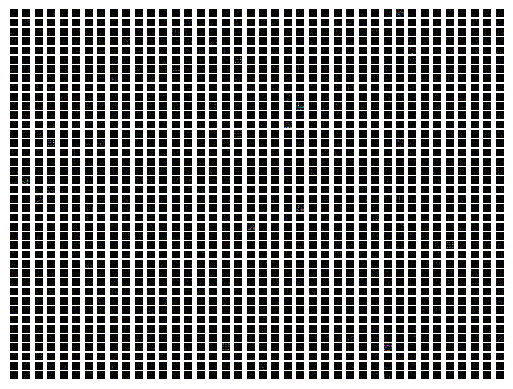

"n_models=n_classes\nminibatch_size = 100\nn_hidden=100\nn_planes=4\nn_iter = 600\nlr=0.005\nprint(n_classes)\nmodel=[]\nfor k in range(n_models):\n    # create models\n    #odel[k] = make_network(n_hidden,n_planes,n_feature)\n    model.append(make_network(n_hidden,n_planes,n_feature))\n\n\nmodel = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)\n\n\ny_pred = np.zeros_like(y_test)\n\nfor i, x in enumerate(X_test):\n    y = np.ones((n_models,))\n    for index, indmodel in enumerate(model, start=0): \n        oop,iop,hop = forward(x, indmodel)\n        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))\n        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()\n    \n    y_pred[i] = y.argmin()\n\n# Compare the predictions with the true labels and take the percentage\naccs= (y_pred == y_test).sum() / y_test.size\n\n\ncnf_matrix = confusion_matrix(y_test, y_pred)\n#print(cnf_matrix)\nplt.figure()

In [7]:
###### eigenbag ###########
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os



# with gzip.open('mnist.pkl.gz', 'rb') as f:
#     try:
#         train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
#     except:
#         train_set, valid_set, test_set = pickle.load(f)
# X_train, y_train = train_set
# X_test, y_test = test_set
# X_Val, y_Val = valid_set  
print(y_train.shape, X_train.shape)
scaler = MinMaxScaler(copy=True, feature_range=(0.1, 0.9))
scaler.fit(X_train)
dataset=scaler.transform(X_train)
print(dataset.shape)

opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeMain(np.transpose(dataset))


        
'''n_models=n_classes
minibatch_size = 100
n_hidden=100
n_planes=4
n_iter = 600
lr=0.005
print(n_classes)
model=[]
for k in range(n_models):
    # create models
    #odel[k] = make_network(n_hidden,n_planes,n_feature)
    model.append(make_network(n_hidden,n_planes,n_feature))


model = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)


y_pred = np.zeros_like(y_test)

for i, x in enumerate(X_test):
    y = np.ones((n_models,))
    for index, indmodel in enumerate(model, start=0): 
        oop,iop,hop = forward(x, indmodel)
        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))
        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()
    
    y_pred[i] = y.argmin()

# Compare the predictions with the true labels and take the percentage
accs= (y_pred == y_test).sum() / y_test.size


cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix,n_classes, normalize=False,
                      title='confusion matrix')

plt.show()
print('Test  accuracy: {}'.format(accs))'''

In [9]:
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os

n_feature=dataset.shape[1]
# print(type(y_train))
if np.min(y_train)==0:
    n_classes=int(np.max(y_train)+1)
else:
    n_classes=int(np.max(y_train))
    y_train=y_train-1
    y_test=y_test-1
    y_Val=y_Val-1

print(opt_b1.shape)



runs=20
fra=0.8
sizeFraction=50
comFactor=50
genDataTrainXFinalClassInc = np.empty(shape=[0, compressedInputs.shape[1]])
genDataTrainYFinalClassInc=np.empty(shape=[0,])
for cl in tqdm(range(n_classes)):
    genDataTrainXFinal = np.empty(shape=[0, compressedInputs.shape[1]])
    data_train=compressedInputs[y_train==cl,:] #select classwise data
    for ru in tqdm(range(runs)):
        #select 40 samples randomly 
        try:
            ranNums=np.random.randint(low=0, high=data_train.shape[0], size=sizeFraction)
            data_train_used=data_train[ranNums,:]
            LP = range(data_train_used.shape[0])

            combP = combinations(LP, comFactor)
            #print(len(list(combP)))
            genDataTrainX = np.empty(shape=[0, data_train.shape[1]])
            for j in list(combP): 
                #print(np.asarray(j))
                X=data_train_used[np.asarray(j),:]

                numClust=10
                kms=KMeans(n_clusters=numClust)
                kms.fit(X)
                y_pred = kms.predict(X)
                clus=kms.cluster_centers_
                #print(y_pred)
                genData = np.empty(shape=[0, X.shape[1]])
                for k in (range(numClust)):
                    tempData=X[y_pred==k,:]
                    #print(tempData.shape)
                    newData=fra*tempData +(1-fra)*np.matlib.repmat(clus[k,:], tempData.shape[0], 1)
                    genData = np.append(genData, newData, axis=0)

                #print('.')
                predictedGenClass=cl*np.ones([genData.shape[0],])
                #project back
                #genDataHigh=pca.inverse_transform(genData)
                #print(genDataHigh.shape)
                genDataTrainX=np.append(genDataTrainX,genData,axis=0)
        except:
            pass
    
        genDataTrainXFinal=np.append(genDataTrainXFinal,genDataTrainX,axis=0) 
        #print(ru)
    genDataTrainYFinalClassInc=np.append(genDataTrainYFinalClassInc,cl*np.ones((genDataTrainXFinal.shape[0],)),axis=0) 
    genDataTrainXFinalClassInc=np.append(genDataTrainXFinalClassInc,genDataTrainXFinal,axis=0) 
    print(cl)
print(genDataTrainXFinalClassInc.shape)
print(genDataTrainYFinalClassInc.shape)

#project back
highDimGen=np.transpose(sigmoid(np.dot(opt_W2, np.transpose(genDataTrainXFinalClassInc)) + opt_b2))

highDimGen=scaler.inverse_transform(highDimGen)

#visualizeW1(highDimGen[2000:2028,:], 28, 28)
X_train1=np.append(X_train,highDimGen,axis=0) 
y_train1 = np.append(y_train,genDataTrainYFinalClassInc,axis=0)
print(X_train1.shape)
print(y_train1.shape)



(1600, 1)


  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0


  0%|          | 0/20 [00:00<?, ?it/s]

1


  0%|          | 0/20 [00:00<?, ?it/s]

2


  0%|          | 0/20 [00:00<?, ?it/s]

3


  0%|          | 0/20 [00:00<?, ?it/s]

4


  0%|          | 0/20 [00:00<?, ?it/s]

5


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/20 [00:00<?, ?it/s]

8


  0%|          | 0/20 [00:00<?, ?it/s]

9


  0%|          | 0/20 [00:00<?, ?it/s]

10


  0%|          | 0/20 [00:00<?, ?it/s]

11


  0%|          | 0/20 [00:00<?, ?it/s]

12


  0%|          | 0/20 [00:00<?, ?it/s]

13


  0%|          | 0/20 [00:00<?, ?it/s]

14


  0%|          | 0/20 [00:00<?, ?it/s]

15


  0%|          | 0/20 [00:00<?, ?it/s]

16


  0%|          | 0/20 [00:00<?, ?it/s]

17


  0%|          | 0/20 [00:00<?, ?it/s]

18


  0%|          | 0/20 [00:00<?, ?it/s]

19


  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

21


  0%|          | 0/20 [00:00<?, ?it/s]

22


  0%|          | 0/20 [00:00<?, ?it/s]

23


  0%|          | 0/20 [00:00<?, ?it/s]

24


  0%|          | 0/20 [00:00<?, ?it/s]

25


  0%|          | 0/20 [00:00<?, ?it/s]

26


  0%|          | 0/20 [00:00<?, ?it/s]

27


  0%|          | 0/20 [00:00<?, ?it/s]

28


  0%|          | 0/20 [00:00<?, ?it/s]

29


  0%|          | 0/20 [00:00<?, ?it/s]

30


  0%|          | 0/20 [00:00<?, ?it/s]

31


  0%|          | 0/20 [00:00<?, ?it/s]

32


  0%|          | 0/20 [00:00<?, ?it/s]

33


  0%|          | 0/20 [00:00<?, ?it/s]

34


  0%|          | 0/20 [00:00<?, ?it/s]

35


  0%|          | 0/20 [00:00<?, ?it/s]

36


  0%|          | 0/20 [00:00<?, ?it/s]

37


  0%|          | 0/20 [00:00<?, ?it/s]

38


  0%|          | 0/20 [00:00<?, ?it/s]

39


  0%|          | 0/20 [00:00<?, ?it/s]

40


  0%|          | 0/20 [00:00<?, ?it/s]

41


  0%|          | 0/20 [00:00<?, ?it/s]

42


  0%|          | 0/20 [00:00<?, ?it/s]

43


  0%|          | 0/20 [00:00<?, ?it/s]

44


  0%|          | 0/20 [00:00<?, ?it/s]

45


  0%|          | 0/20 [00:00<?, ?it/s]

46


  0%|          | 0/20 [00:00<?, ?it/s]

47


  0%|          | 0/20 [00:00<?, ?it/s]

48


  0%|          | 0/20 [00:00<?, ?it/s]

49


  0%|          | 0/20 [00:00<?, ?it/s]

50


  0%|          | 0/20 [00:00<?, ?it/s]

51


  0%|          | 0/20 [00:00<?, ?it/s]

52


  0%|          | 0/20 [00:00<?, ?it/s]

53


  0%|          | 0/20 [00:00<?, ?it/s]

54


  0%|          | 0/20 [00:00<?, ?it/s]

55


  0%|          | 0/20 [00:00<?, ?it/s]

56


  0%|          | 0/20 [00:00<?, ?it/s]

57


  0%|          | 0/20 [00:00<?, ?it/s]

58


  0%|          | 0/20 [00:00<?, ?it/s]

59


  0%|          | 0/20 [00:00<?, ?it/s]

60


  0%|          | 0/20 [00:00<?, ?it/s]

61


  0%|          | 0/20 [00:00<?, ?it/s]

62


  0%|          | 0/20 [00:00<?, ?it/s]

63


  0%|          | 0/20 [00:00<?, ?it/s]

64


  0%|          | 0/20 [00:00<?, ?it/s]

65


  0%|          | 0/20 [00:00<?, ?it/s]

66


  0%|          | 0/20 [00:00<?, ?it/s]

67


  0%|          | 0/20 [00:00<?, ?it/s]

68


  0%|          | 0/20 [00:00<?, ?it/s]

69


  0%|          | 0/20 [00:00<?, ?it/s]

70


  0%|          | 0/20 [00:00<?, ?it/s]

71


  0%|          | 0/20 [00:00<?, ?it/s]

72


  0%|          | 0/20 [00:00<?, ?it/s]

73


  0%|          | 0/20 [00:00<?, ?it/s]

74


  0%|          | 0/20 [00:00<?, ?it/s]

75


  0%|          | 0/20 [00:00<?, ?it/s]

76


  0%|          | 0/20 [00:00<?, ?it/s]

77


  0%|          | 0/20 [00:00<?, ?it/s]

78


  0%|          | 0/20 [00:00<?, ?it/s]

79


  0%|          | 0/20 [00:00<?, ?it/s]

80


  0%|          | 0/20 [00:00<?, ?it/s]

81


  0%|          | 0/20 [00:00<?, ?it/s]

82


  0%|          | 0/20 [00:00<?, ?it/s]

83


  0%|          | 0/20 [00:00<?, ?it/s]

84


  0%|          | 0/20 [00:00<?, ?it/s]

85


  0%|          | 0/20 [00:00<?, ?it/s]

86


  0%|          | 0/20 [00:00<?, ?it/s]

87


  0%|          | 0/20 [00:00<?, ?it/s]

88


  0%|          | 0/20 [00:00<?, ?it/s]

89


  0%|          | 0/20 [00:00<?, ?it/s]

90


  0%|          | 0/20 [00:00<?, ?it/s]

91


  0%|          | 0/20 [00:00<?, ?it/s]

92


  0%|          | 0/20 [00:00<?, ?it/s]

93


  0%|          | 0/20 [00:00<?, ?it/s]

94


  0%|          | 0/20 [00:00<?, ?it/s]

95


  0%|          | 0/20 [00:00<?, ?it/s]

96


  0%|          | 0/20 [00:00<?, ?it/s]

97


  0%|          | 0/20 [00:00<?, ?it/s]

98


  0%|          | 0/20 [00:00<?, ?it/s]

99


  0%|          | 0/20 [00:00<?, ?it/s]

100


  0%|          | 0/20 [00:00<?, ?it/s]

101


  0%|          | 0/20 [00:00<?, ?it/s]

102


  0%|          | 0/20 [00:00<?, ?it/s]

103


  0%|          | 0/20 [00:00<?, ?it/s]

104


  0%|          | 0/20 [00:00<?, ?it/s]

105


  0%|          | 0/20 [00:00<?, ?it/s]

106


  0%|          | 0/20 [00:00<?, ?it/s]

107


  0%|          | 0/20 [00:00<?, ?it/s]

108


  0%|          | 0/20 [00:00<?, ?it/s]

109


  0%|          | 0/20 [00:00<?, ?it/s]

110


  0%|          | 0/20 [00:00<?, ?it/s]

111


  0%|          | 0/20 [00:00<?, ?it/s]

112


  0%|          | 0/20 [00:00<?, ?it/s]

113


  0%|          | 0/20 [00:00<?, ?it/s]

114


  0%|          | 0/20 [00:00<?, ?it/s]

115


  0%|          | 0/20 [00:00<?, ?it/s]

116


  0%|          | 0/20 [00:00<?, ?it/s]

117


  0%|          | 0/20 [00:00<?, ?it/s]

118


  0%|          | 0/20 [00:00<?, ?it/s]

119


  0%|          | 0/20 [00:00<?, ?it/s]

120


  0%|          | 0/20 [00:00<?, ?it/s]

121


  0%|          | 0/20 [00:00<?, ?it/s]

122


  0%|          | 0/20 [00:00<?, ?it/s]

123


  0%|          | 0/20 [00:00<?, ?it/s]

124


  0%|          | 0/20 [00:00<?, ?it/s]

125


  0%|          | 0/20 [00:00<?, ?it/s]

126


  0%|          | 0/20 [00:00<?, ?it/s]

127


  0%|          | 0/20 [00:00<?, ?it/s]

128


  0%|          | 0/20 [00:00<?, ?it/s]

129


  0%|          | 0/20 [00:00<?, ?it/s]

130


  0%|          | 0/20 [00:00<?, ?it/s]

131


  0%|          | 0/20 [00:00<?, ?it/s]

132


  0%|          | 0/20 [00:00<?, ?it/s]

133


  0%|          | 0/20 [00:00<?, ?it/s]

134


  0%|          | 0/20 [00:00<?, ?it/s]

135


  0%|          | 0/20 [00:00<?, ?it/s]

136


  0%|          | 0/20 [00:00<?, ?it/s]

137


  0%|          | 0/20 [00:00<?, ?it/s]

138


  0%|          | 0/20 [00:00<?, ?it/s]

139


  0%|          | 0/20 [00:00<?, ?it/s]

140


  0%|          | 0/20 [00:00<?, ?it/s]

141


  0%|          | 0/20 [00:00<?, ?it/s]

142


  0%|          | 0/20 [00:00<?, ?it/s]

143


  0%|          | 0/20 [00:00<?, ?it/s]

144


  0%|          | 0/20 [00:00<?, ?it/s]

145
(146000, 1600)
(146000,)
(147458, 12288)
(147458,)


In [10]:
import six.moves.cPickle as pickle
from sklearn.utils import shuffle

# X_test, y_test = test_set
# X_Val, y_Val = valid_set  
X_train1, y_train1 = shuffle(X_train1, y_train1)
scaler1 = MinMaxScaler(copy=True, feature_range=(-0.9, 0.9))
scaler.fit(X_train1)
X_train1=scaler.transform(X_train1)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [11]:
X_train1=X_train1.reshape(-1,*Xtrainshape[1:])
X_val=X_val.reshape(Xvalshape)
X_test=X_test.reshape(Xtestshape)

In [12]:
print(X_train1.shape)
# Total_data = np.array([X_train1, y_train1,X_val,y_val,X_test,y_test])
# np.save(f'Knee_{imgsize}_{X_train1.shape[0]}', Total_data)
with open(f'EigenData/Lavina_{imgsize}_{X_train1.shape[0]}_LBUB.bin', 'wb') as f:
    pickle.dump([X_train1, y_train1,X_val,y_val,X_test,y_test], f, protocol=4)

(147458, 3, 64, 64)


In [13]:
%matplotlib inline

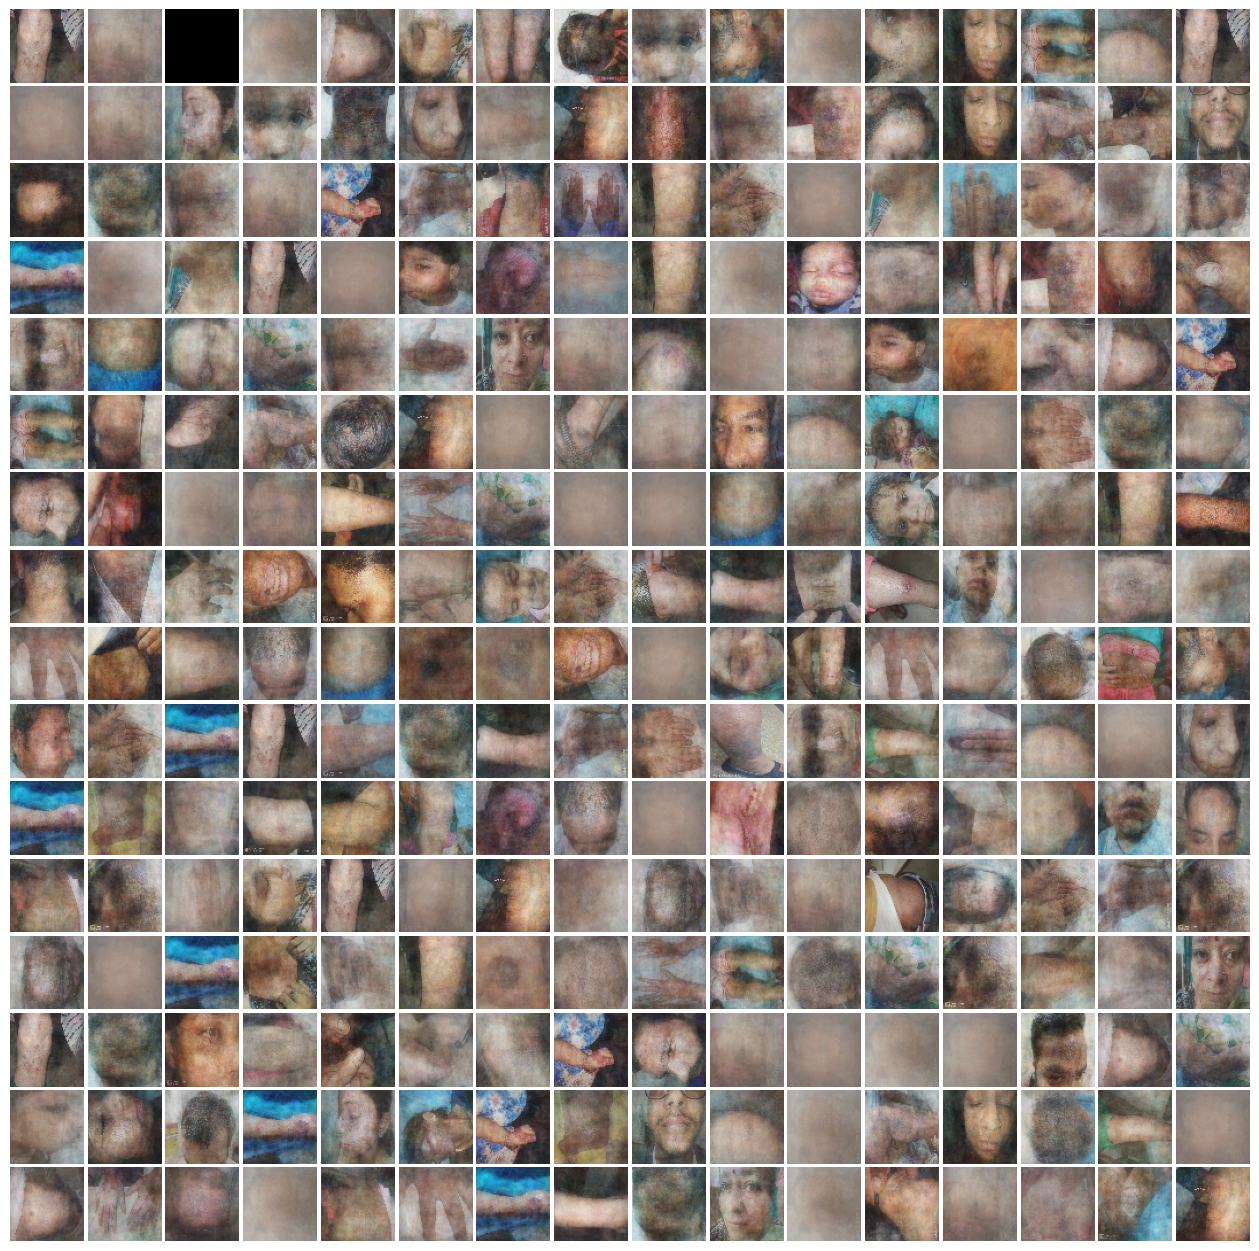

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(16, 16)
gs.update(wspace=0.05, hspace=0.05)
# plt.imshow(X_train1[0].transpose(1,2,0))
samples=X_train1[0:256,:] #highDimGen
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    if i == 2:
        plt.imshow(np.zeros((64,64,3))) # just to show how indexing is done
    else:
        plt.imshow(sample.transpose(1,2,0))

In [25]:
print(y_train[0:256])

[ 39  43  53  97   1  30  97   9  97 104  85  45   3  85  53   4  62  55
  87   1   1  87  53   1   1  87 104   1   4  97   9   1  87  10  85  39
  53   9   9  73  45  45  69  97  97  85  85  43 104  31  45   5  64  87
  85   1   9 104  97  85  39  97  85  97  64  64   9  69  87   9  54 104
  85  13   9   9  44   9  87  45   9  97 131 104  97  89  13  85   4  87
  97  97  96   8   1  53   9  53  97   0  39  54  39 104   7  44  45  25
  30  97  78 104  38   9  39  97   1  54  87  64   1  97   4  85  97  89
   4  85 104 107  10  64  44  12  44   2  97  75  97  85 104  85   1  85
  97  87   5 104  99   9  39  97 104   1  63 104  75  85  53  97  97   1
  44  85 104   1  39  53   4 104  75   4  87  53  97  39 104  87  54   9
 104  97  97   1   9  78  97 104  97   5  10  85   4   9  73  62 130 131
  87  45  42  38  57  85   1  85  85 131  87   1  87 103  78  76  83  39
   9  87  62   1  98  85  62   4 131 104  85 104  85  45  63   1   3  10
   1   4  97  75  42   0  97 104  43 104  97   1   

In [27]:
full_dataset.find_classes('/data/siddhant/MedicalSTN/LavinaData')[1]

{'Acanthosis nigricans': 0,
 'Acne': 1,
 'Acne Kleidalis nuche': 2,
 'Acrochordon or Skin tags': 3,
 'Alopecia Areata': 4,
 'Androgenetic alopecia': 5,
 'Angiofibroma': 6,
 'Anogenital warts': 7,
 'Atopic dermatitis': 8,
 'Basal cell carcinoma': 9,
 'Becker_s nevus': 10,
 'Bowenoid Papulosis': 11,
 'Bowens disease': 12,
 'Bullous impetigo': 13,
 'Bullous pemphigoid': 14,
 'Candidiasis': 15,
 'Capillary lymphatic malformation': 16,
 'Chicken pox': 17,
 'Chronic paronychia': 18,
 'Collagenoma': 19,
 'Corn': 20,
 'Cut horn': 21,
 'Cutaneous metastasis': 22,
 'Dermatitis cruris pustulosa et atrophicans': 23,
 'Dermatofibroma': 24,
 'Discoid lupus erythematosus': 25,
 'EB pruriginosa': 26,
 'Ecythma': 27,
 'Epidermoid cyst(sebaceous cyst)': 28,
 'Erythroderma': 29,
 'Female patterned hair loss': 30,
 'Fixed drug eruption': 31,
 'Freckles': 32,
 'Fric Blister': 33,
 'Furuncle': 34,
 'Geographic tongue': 35,
 'Hailey Hailey disease': 36,
 'Henoch schonlein purpura': 37,
 'Herpes zoster': 38,
